In [1]:
!git clone https://github.com/TaeniKim/nbeats_reproduce.git

Cloning into 'nbeats_reproduce'...
remote: Enumerating objects: 89, done.
remote: Counting objects: 100% (17/17), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 89 (delta 1), reused 16 (delta 1), pack-reused 72
Unpacking objects: 100% (89/89), done.
Checking out files: 100% (34/34), done.


In [ ]:
!pip install neuralforecast

In [1]:
import neuralforecast as nf
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import torch as t
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupShuffleSplit

from typing import Tuple
from pathlib import Path

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# --------------------------------------- DATA PRE-PROCESSING ---------------------------------------
def add_remaining_useful_life(df):
    # Get the total number of cycles for each unit
    grouped_by_unit = df.groupby(by="unit_nr")
    max_cycle = grouped_by_unit["time_cycles"].max()
    
    # Merge the max cycle back into the original frame
    result_frame = df.merge(max_cycle.to_frame(name='max_cycle'), left_on='unit_nr', right_index=True)
    
    # Calculate remaining useful life for each row
    remaining_useful_life = result_frame["max_cycle"] - result_frame["time_cycles"]
    result_frame["RUL"] = remaining_useful_life
    
    # drop max_cycle as it's no longer needed
    result_frame = result_frame.drop("max_cycle", axis=1)
    return result_frame

def add_operating_condition(df):
    df_op_cond = df.copy()
    
    df_op_cond['setting_1'] = abs(df_op_cond['setting_1'].round())
    df_op_cond['setting_2'] = abs(df_op_cond['setting_2'].round(decimals=2))
    
    # converting settings to string and concatanating makes the operating condition into a categorical variable
    df_op_cond['op_cond'] = df_op_cond['setting_1'].astype(str) + '_' + \
                        df_op_cond['setting_2'].astype(str) + '_' + \
                        df_op_cond['setting_3'].astype(str)
    
    return df_op_cond

def condition_scaler(df_train, df_test, sensor_names):
    # apply operating condition specific scaling
    scaler = StandardScaler()
    for condition in df_train['op_cond'].unique():
        scaler.fit(df_train.loc[df_train['op_cond']==condition, sensor_names])
        df_train.loc[df_train['op_cond']==condition, sensor_names] = scaler.transform(df_train.loc[df_train['op_cond']==condition, sensor_names])
        df_test.loc[df_test['op_cond']==condition, sensor_names] = scaler.transform(df_test.loc[df_test['op_cond']==condition, sensor_names])
    return df_train, df_test

def exponential_smoothing(df, sensors, n_samples, alpha=0.4):
    df = df.copy()
    # first, take the exponential weighted mean
    df[sensors] = df.groupby('unit_nr')[sensors].apply(lambda x: x.ewm(alpha=alpha).mean()).reset_index(level=0, drop=True)
    
    # second, drop first n_samples of each unit_nr to reduce filter delay
    def create_mask(data, samples):
        result = np.ones_like(data)
        result[0:samples] = 0
        return result
    
    mask = df.groupby('unit_nr')['unit_nr'].transform(create_mask, samples=n_samples).astype(bool)
    df = df[mask]
    
    return df

def gen_train_data(df, sequence_length, columns):
    data = df[columns].values
    num_elements = data.shape[0]

    # -1 and +1 because of Python indexing
    for start, stop in zip(range(0, num_elements-(sequence_length-1)), range(sequence_length, num_elements+1)):
        yield data[start:stop, :]
        
def gen_data_wrapper(df, sequence_length, columns, unit_nrs=np.array([])):
    if unit_nrs.size <= 0:
        unit_nrs = df['unit_nr'].unique()
        
    data_gen = (list(gen_train_data(df[df['unit_nr']==unit_nr], sequence_length, columns))
               for unit_nr in unit_nrs)
    data_array = np.concatenate(list(data_gen)).astype(np.float32)
    return data_array

def gen_labels(df, sequence_length, label):
    data_matrix = df[label].values
    num_elements = data_matrix.shape[0]

    # -1 because I want to predict the rul of that last row in the sequence, not the next row
    return data_matrix[sequence_length-1:num_elements, :]  

def gen_label_wrapper(df, sequence_length, label, unit_nrs=np.array([])):
    if unit_nrs.size <= 0:
        unit_nrs = df['unit_nr'].unique()
        
    label_gen = [gen_labels(df[df['unit_nr']==unit_nr], sequence_length, label) 
                for unit_nr in unit_nrs]
    label_array = np.concatenate(label_gen).astype(np.float32)
    return label_array

def gen_test_data(df, sequence_length, columns, mask_value):
    if df.shape[0] < sequence_length:
        data_matrix = np.full(shape=(sequence_length, len(columns)), fill_value=mask_value) # pad
        idx = data_matrix.shape[0] - df.shape[0]
        data_matrix[idx:,:] = df[columns].values  # fill with available data
    else:
        data_matrix = df[columns].values
        
    # specifically yield the last possible sequence
    stop = data_matrix.shape[0]
    start = stop - sequence_length
    for i in list(range(1)):
        yield data_matrix[start:stop, :]  

def get_data(dataset, sensors, sequence_length, alpha, threshold):
	# files
	dir_path = '/content/nbeats_reproduce/datasets/cmapss/'
	train_file = 'train_'+dataset+'.txt'
	test_file = 'test_'+dataset+'.txt'
    # columns
	index_names = ['unit_nr', 'time_cycles']
	setting_names = ['setting_1', 'setting_2', 'setting_3']
	sensor_names = ['s_{}'.format(i+1) for i in range(0,21)]
	col_names = index_names + setting_names + sensor_names
    # data readout
	train = pd.read_csv((dir_path+train_file), sep=r'\s+', header=None, 
					 names=col_names)
	test = pd.read_csv((dir_path+test_file), sep=r'\s+', header=None, 
					 names=col_names)
	y_test = pd.read_csv((dir_path+'RUL_'+dataset+'.txt'), sep=r'\s+', header=None, 
					 names=['RemainingUsefulLife'])

    # create RUL values according to the piece-wise target function
	train = add_remaining_useful_life(train)
	train['RUL'].clip(upper=threshold, inplace=True)

    # remove unused sensors
	drop_sensors = [element for element in sensor_names if element not in sensors]

    # scale with respect to the operating condition
	X_train_pre = add_operating_condition(train.drop(drop_sensors, axis=1))
	X_test_pre = add_operating_condition(test.drop(drop_sensors, axis=1))
	X_train_pre, X_test_pre = condition_scaler(X_train_pre, X_test_pre, sensors)

    # exponential smoothing
	X_train_pre= exponential_smoothing(X_train_pre, sensors, 0, alpha)
	X_test_pre = exponential_smoothing(X_test_pre, sensors, 0, alpha)
    

	# train-val split
	gss = GroupShuffleSplit(n_splits=1, train_size=0.80, random_state=42)
	# generate the train/val for *each* sample -> for that we iterate over the train and val units we want
	# this is a for that iterates only once and in that iterations at the same time iterates over all the values we want,
	# i.e. train_unit and val_unit are not a single value but a set of training/vali units
	for train_unit, val_unit in gss.split(X_train_pre['unit_nr'].unique(), groups=X_train_pre['unit_nr'].unique()): 
		train_unit = X_train_pre['unit_nr'].unique()[train_unit]  # gss returns indexes and index starts at 1
		val_unit = X_train_pre['unit_nr'].unique()[val_unit]

		x_train = gen_data_wrapper(X_train_pre, sequence_length, sensors, train_unit)
		y_train = gen_data_wrapper(X_train_pre, sequence_length, ['RUL'], train_unit)
		
		x_val = gen_data_wrapper(X_train_pre, sequence_length, sensors, val_unit)
		y_val = gen_data_wrapper(X_train_pre, sequence_length, ['RUL'], val_unit)
  
  # create sequences for test 
	test_unit = X_test_pre['unit_nr'].unique()
	x_test_index = [len(X_test_pre[X_test_pre.unit_nr == c]) for c in test_unit]
	x_test = gen_data_wrapper(X_test_pre, sequence_length, sensors, test_unit)
    
	#test_gen = (list(gen_test_data(X_test_pre[X_test_pre['unit_nr']==unit_nr], sequence_length, sensors, -99.))
	#		   for unit_nr in X_test_pre['unit_nr'].unique())
	#x_test = np.concatenate(list(test_gen)).astype(np.float32)

	y_test = [list(range(v+sequence_length-1, v-1, -1)) for i, v in enumerate(y_test['RemainingUsefulLife'])]
	y_test = np.array(y_test, dtype='float32')
	y_test = y_test[:,:, np.newaxis]    
    
	return x_train, y_train, x_val, y_val, x_test, y_test, x_test_index

In [3]:
###############################################################################
class NBeatsBlock(t.nn.Module):
    """
    N-BEATS block which takes a basis function as an argument.
    """
    def __init__(self,
                 input_size: int,
                 theta_size: int,
                 basis_function: t.nn.Module,
                 layers: int,
                 layer_size: int):
        """
        N-BEATS block.

        :param input_size: Insample size.
        :param theta_size:  Number of parameters for the basis function.
        :param basis_function: Basis function which takes the parameters and produces backcast and forecast.
        :param layers: Number of layers.
        :param layer_size: Layer size.
        """
        super().__init__()
        self.layers = t.nn.ModuleList([t.nn.Linear(in_features=input_size, out_features=layer_size)] +
                                      [t.nn.Linear(in_features=layer_size, out_features=layer_size)
                                       for _ in range(layers - 1)])
        self.basis_parameters = t.nn.Linear(in_features=layer_size, out_features=theta_size)
        self.basis_function = basis_function

    def forward(self, x: t.Tensor) -> Tuple[t.Tensor, t.Tensor]:
        block_input = x
        for layer in self.layers:
            block_input = t.relu(layer(block_input))
        basis_parameters = self.basis_parameters(block_input)
        return self.basis_function(basis_parameters)


class NBeats(t.nn.Module):
    """
    N-Beats Model.
    """
    def __init__(self, blocks: t.nn.ModuleList):
        super().__init__()
        self.blocks = blocks

    def forward(self, x: t.Tensor, input_mask: t.Tensor) -> t.Tensor:
        residuals = x.flip(dims=(1,)) # left<->right
        input_mask = input_mask.flip(dims=(1,)) # left<->right
        forecast = x[:, -1:]
        for i, block in enumerate(self.blocks):
            backcast, block_forecast = block(residuals)
            residuals = (residuals - backcast) * input_mask
            forecast = forecast + block_forecast
        return forecast
    
    
class GenericBasis(t.nn.Module):
    """
    Generic basis function.
    """
    def __init__(self, backcast_size: int, forecast_size: int):
        super().__init__()
        self.backcast_size = backcast_size
        self.forecast_size = forecast_size

    def forward(self, theta: t.Tensor):
        return theta[:, :self.backcast_size], theta[:, -self.forecast_size:]

In [4]:
## ----------------------------------------------------------------------------
## Prepare - Dataset
dataset = "FD001"
# sensors to work with: T30, T50, P30, PS30, phi
fix_col = ['unit_nr', 'time_cycles']
sensors = ['s_3', 's_4', 's_7', 's_11', 's_12']
# windows length
sequence_length = 30
# smoothing intensity
alpha = 0.1
# max RUL
threshold = 125

x_train, y_train, x_val, y_val, x_test, y_test, x_test_index = get_data(dataset, sensors, sequence_length, alpha, threshold)

x_train_re = x_train.reshape(x_train.shape[0], x_train.shape[1]*x_train.shape[2])
y_train_re = y_train.reshape(y_train.shape[0], y_train.shape[1]*y_train.shape[2])
x_val_re = x_val.reshape(x_val.shape[0], x_val.shape[1]*x_val.shape[2])
y_val_re = y_val.reshape(y_val.shape[0], y_val.shape[1]*y_val.shape[2])
x_test_re = x_test.reshape(x_test.shape[0], x_test.shape[1]*x_val.shape[2])
y_test_re = y_test.reshape(y_test.shape[0], y_test.shape[1]*y_val.shape[2])

In [5]:
x_test_index_re = [(v - 30 +1) for v in x_test_index]
x_test_index_re2 = []
buf = 0
for i, v in enumerate(x_test_index_re):
    if i==0:
        x_test_index_re2.append([0, x_test_index_re[0]])
        buf =  x_test_index_re[0]
        continue
    buf += x_test_index_re[i]
    x_test_index_re2.append([x_test_index_re2[i-1][1], buf])

In [6]:
x_test_index_re2[:5]

[[0, 2], [2, 22], [22, 119], [119, 196], [196, 265]]

In [7]:
## ----------------------------------------------------------------------------
## Make model
window_size = sequence_length
input_dim = len(sensors)
output_dim = 1 # RUL

timeseries = x_train
batch_size = 512
insample_size = window_size * input_dim # 30 * 5
outsample_size = window_size * output_dim # 30 * 1
theta_size = insample_size + outsample_size
stacks = 3
layers = 4
layer_size = 512


model = NBeats(t.nn.ModuleList([NBeatsBlock(input_size=insample_size,
                                            theta_size=theta_size,
                                            basis_function=GenericBasis(backcast_size = insample_size,
                                                                        forecast_size = outsample_size),
                                            layers=layers,
                                            layer_size=layer_size)
                                for _ in range(stacks)]))


default_device = t.device('cuda' if t.cuda.is_available() else 'cpu')
model = model.to(default_device)

learning_rate = 0.00001
optimizer = t.optim.Adam(model.parameters(), lr=learning_rate)
training_loss_fn = t.nn.MSELoss()
iterations = 5000
lr_decay_step = iterations // 3            
if lr_decay_step == 0:
    lr_decay_step = 1

In [8]:
def to_tensor(array: np.ndarray) -> t.Tensor:
        """
        Convert numpy array to tensor on default device.
    
        :param array: Numpy array to convert.
        :return: PyTorch tensor on default device.
        """
        return t.tensor(array, dtype=t.float32).to(default_device)

his_train = []
min_valid_loss = 99999
cnt_valid_loss = 0
for i in range(1, iterations + 1):
    # train
    model.train()
    x = x_train_re
    x_mask = np.ones(shape=x.shape, dtype=np.float32)
    y = y_train_re
    y_mask = np.ones(shape=y.shape, dtype=np.float32)    
    
    x, x_mask, y, y_mask = map(to_tensor, (x, x_mask, y, y_mask))

    optimizer.zero_grad() # init gradients before back-propagation
    forecast = model(x, x_mask)
    training_loss = training_loss_fn(forecast, y)

    if np.isnan(float(training_loss)):
        break

    training_loss.backward()
    t.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    optimizer.step()

    for param_group in optimizer.param_groups:
        param_group["lr"] = learning_rate * 0.5 ** (i // lr_decay_step)

    def check_directorys(f: str) -> None:
        if not Path(f).is_dir():
            print(f"create directory: {f.split(sep='/')[-1]}")
            Path(f).mkdir(parents=True, exist_ok=True)
            

    if i % 100 == 1:
        # valid
        model.eval()
        x = x_val_re
        x_mask = np.ones(shape=x.shape, dtype=np.float32)
        y = y_val_re
        y_mask = np.ones(shape=y.shape, dtype=np.float32)   

        x, x_mask, y, y_mask = map(to_tensor, (x, x_mask, y, y_mask))

        forecast = model(x, x_mask)
        valid_loss = training_loss_fn(forecast, y)

        f = r'./steps/FD001/'
        check_directorys(f)
        f += f'weight_iter_{i}.pth'
        print('Save Model:', f)
        t.save(model, f)
        print(f'iter:{i}/{iterations} \t train_loss:{training_loss:.3f} \t val_loss:{valid_loss:.3f}') 
        his_train.append([i, training_loss, valid_loss])

        if valid_loss < min_valid_loss:
            min_valid_loss = valid_loss
            cnt_valid_loss = 0
        else:
            cnt_valid_loss += 1

        if cnt_valid_loss >= 5:
            print('Early stop..!!')
            break

Save Model: ./steps/FD001/weight_iter_1.pth
iter:1/5000 	 train_loss:9481.779 	 val_loss:9358.037
Save Model: ./steps/FD001/weight_iter_101.pth
iter:101/5000 	 train_loss:9429.812 	 val_loss:9303.088
Save Model: ./steps/FD001/weight_iter_201.pth
iter:201/5000 	 train_loss:8907.324 	 val_loss:8748.599
Save Model: ./steps/FD001/weight_iter_301.pth
iter:301/5000 	 train_loss:3422.858 	 val_loss:3439.023
Save Model: ./steps/FD001/weight_iter_401.pth
iter:401/5000 	 train_loss:2714.901 	 val_loss:2682.159
Save Model: ./steps/FD001/weight_iter_501.pth
iter:501/5000 	 train_loss:1444.666 	 val_loss:1405.700
Save Model: ./steps/FD001/weight_iter_601.pth
iter:601/5000 	 train_loss:325.963 	 val_loss:248.336
Save Model: ./steps/FD001/weight_iter_701.pth
iter:701/5000 	 train_loss:165.111 	 val_loss:155.617
Save Model: ./steps/FD001/weight_iter_801.pth
iter:801/5000 	 train_loss:149.623 	 val_loss:146.178
Save Model: ./steps/FD001/weight_iter_901.pth
iter:901/5000 	 train_loss:142.846 	 val_loss:

In [9]:
# Evaluate
x_mask = np.ones(shape=x_test_re.shape, dtype=np.float32)
x, x_mask = map(to_tensor, (x_test_re, x_mask))

model.eval()
forecasts = []
with t.no_grad():
    forecasts.extend(model(x, x_mask).cpu().detach().numpy())   

In [10]:
len(forecasts)

10196

In [11]:
unit_no = 34
t_len = x_test[unit_no-1] - 30 + 1 # sample length
s_idx = x_test_index_re2[unit_no-1][0]
e_idx = x_test_index_re2[unit_no-1][1]

df = pd.DataFrame([v[-1] for v in forecasts[s_idx:e_idx]], columns=['y_hat'])

tt = np.arange(y_test[:][:][unit_no-1][29], y_test[:][:][unit_no-1][29] + len(df.y_hat))
tt = np.flip(tt)
test = lambda v:125 if v>125 else v
df['y'] = pd.DataFrame([test(v) for v in tt], columns=['y']) 

In [12]:
df.tail()

,y_hat,y
169,8.418749,11.0
170,6.505460,10.0
171,5.959170,9.0
172,4.855988,8.0
173,3.576194,7.0


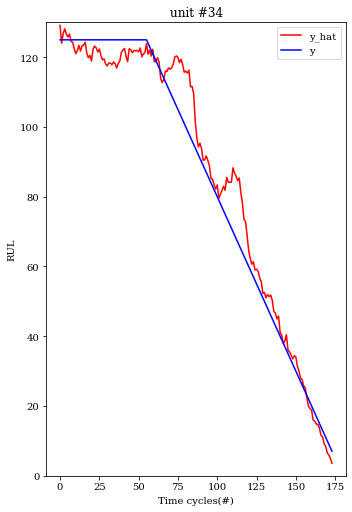

In [13]:
fig, ax1 = plt.subplots(figsize=(5, 7))

ax1.set_xlabel('Time cycles(#)')
ax1.set_ylabel('RUL')
ax1.set_ylim([0, 130])
ax1.plot(df['y_hat'], color='red', label='y_hat')
ax1.plot(df['y'], color='blue', label='y')
ax1.legend()

fig.tight_layout()
plt.title('unit #' + str(unit_no))
plt.show()

In [27]:
lst_his=[]
for h in his_train:
    lst_his.append([h[0], h[1].item(), h[2].item()])

df = pd.DataFrame(lst_his, columns=['iter','train','valid'])
df.head()

,iter,train,valid
0,1,9481.779297,9358.037109
1,101,9429.812500,9303.087891
2,201,8907.324219,8748.598633
3,301,3422.857910,3439.022705
4,401,2714.900879,2682.159424


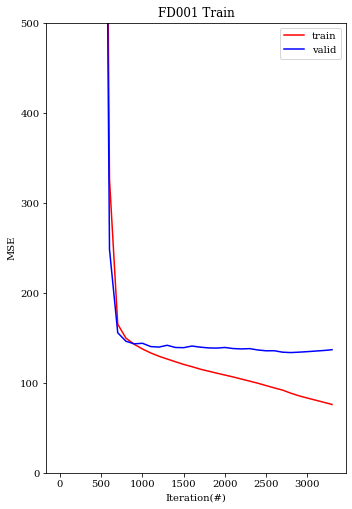

In [31]:
fig, ax1 = plt.subplots(figsize=(5, 7))

ax1.set_xlabel('Iteration(#)')
ax1.set_ylabel('MSE')
ax1.set_ylim([0, 500])
ax1.plot(df.iter, df.train, color='red', label='train')
ax1.plot(df.iter, df.valid, color='blue', label='valid')
ax1.legend()

fig.tight_layout()
plt.title('FD001 Train')
plt.show()